In [1]:
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models

from NetworkAPI import NetworkAPI

np.random.seed=0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data loaders

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.RandomCrop(28, padding=4),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', 
                                                  transform=data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=256, 
                                              shuffle=True, 
                                              num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Network example architecture

In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Output is 128x8x8
            nn.ReLU(inplace=True), # Output is 128x8x8
            nn.BatchNorm2d(128), # Output is 128x8x8
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),# Output is 128x8x8
            nn.ReLU(inplace=True), # Output is 128x8x8
            nn.BatchNorm2d(128), # Output is 128x8x8
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 128x4x4
            nn.Dropout2d(0.4)
        )
        self.flatten = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = self.conv3(x) # Change size from 64x16x16 to 128x16x16
        x = x.view(-1, 128*4*4) # Change size from 128x16x16 to 1x2048
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## Network tests

### densenet121

In [9]:
dense_model = models.densenet121(pretrained=False)
num_ftrs = dense_model.classifier.in_features
dense_model.classifier = nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax(-1))
# resnet_model.classifier.requires_grad = True
dense_model = dense_model.to(device)

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 10
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  59.42s | Train loss:  2.16 | Train acc: 31.36|
| Epoch:   1 | Time:  31.71s | Val loss:    2.06 | Val acc:   40.74|
--------------------------------------------------------------------
| Epoch:   2 | Time:  65.35s | Train loss:  2.02 | Train acc: 44.91|
| Epoch:   2 | Time:  34.32s | Val loss:    2.00 | Val acc:   46.90|
--------------------------------------------------------------------
| Epoch:   3 | Time:  67.44s | Train loss:  1.97 | Train acc: 49.84|
| Epoch:   3 | Time:  35.49s | Val loss:    1.95 | Val acc:   51.08|
--------------------------------------------------------------------
| Epoch:   4 | Time:  69.01s | Train loss:  1.93 | Train acc: 52.75|
| Epoch:   4 | Time:  37.60s | Val loss:    1.96 | Val acc:   49.63|
--------------------------------------------------------------------
| Epoch:  

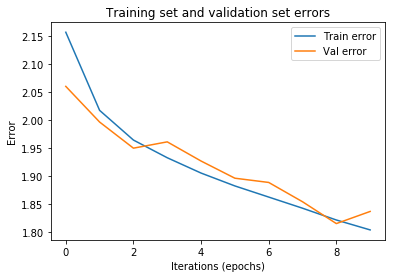

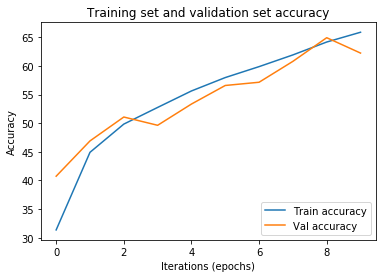

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 76.28% | 76.38%|
| Accuracy of: automobile | 87.50% | 88.28%|
| Accuracy of: bird       | 36.34% | 36.34%|
| Accuracy of: cat        | 34.32% | 34.60%|
| Accuracy of: deer       | 52.22% | 52.46%|
| Accuracy of: dog        | 56.12% | 56.66%|
| Accuracy of: frog       | 63.00% | 63.06%|
| Accuracy of: horse      | 65.62% | 65.50%|
| Accuracy of: ship       | 82.80% | 82.40%|
| Accuracy of: truck      | 67.22% | 66.82%|


In [10]:
brain = NetworkAPI(dense_model, dataloaders, 'densenet', lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=10)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

### my architecture

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 10
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  25.82s | Train loss:  2.18 | Train acc: 28.77|
| Epoch:   1 | Time:  11.85s | Val loss:    2.05 | Val acc:   41.89|
--------------------------------------------------------------------
| Epoch:   2 | Time:  27.67s | Train loss:  2.04 | Train acc: 43.10|
| Epoch:   2 | Time:  11.02s | Val loss:    2.00 | Val acc:   46.24|
--------------------------------------------------------------------
| Epoch:   3 | Time:  26.26s | Train loss:  1.98 | Train acc: 48.69|
| Epoch:   3 | Time:  11.85s | Val loss:    1.95 | Val acc:   51.27|
--------------------------------------------------------------------
| Epoch:   4 | Time:  30.30s | Train loss:  1.92 | Train acc: 53.99|
| Epoch:   4 | Time:  10.92s | Val loss:    1.87 | Val acc:   59.74|
--------------------------------------------------------------------
| Epoch:  

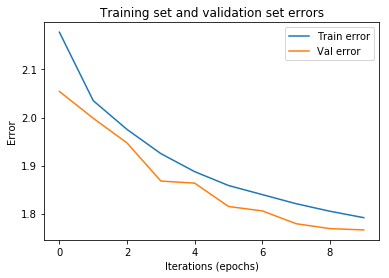

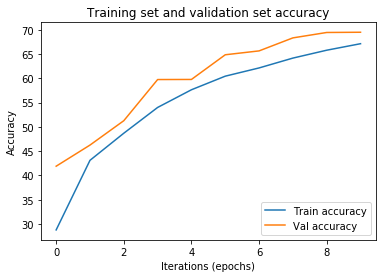

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 77.42% | 77.06%|
| Accuracy of: automobile | 84.58% | 84.24%|
| Accuracy of: bird       | 50.30% | 50.36%|
| Accuracy of: cat        | 33.80% | 33.48%|
| Accuracy of: deer       | 60.58% | 61.06%|
| Accuracy of: dog        | 66.00% | 66.50%|
| Accuracy of: frog       | 78.86% | 79.14%|
| Accuracy of: horse      | 76.44% | 75.98%|
| Accuracy of: ship       | 85.02% | 85.28%|
| Accuracy of: truck      | 82.04% | 81.76%|


In [11]:
model = Network().to(device)
brain = NetworkAPI(model, dataloaders, 'my_architecture', lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=10)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Reload checkpoints from network (if saved)

====== HYPERPARAMETERS ======
starting epoch= 8
epochs to go= 3
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   9 | Time:  70.42s | Train loss:  1.80 | Train acc: 66.10|
| Epoch:   9 | Time:  41.03s | Val loss:    1.82 | Val acc:   63.75|
--------------------------------------------------------------------
| Epoch:  10 | Time:  70.58s | Train loss:  1.79 | Train acc: 67.44|
| Epoch:  10 | Time:  41.79s | Val loss:    1.82 | Val acc:   64.39|
--------------------------------------------------------------------
| Epoch:  11 | Time:  71.16s | Train loss:  1.78 | Train acc: 68.58|
| Epoch:  11 | Time:  40.72s | Val loss:    1.78 | Val acc:   67.89|
--------------------------------------------------------------------
| Total time elapsed: 5 minutes 35 seconds 


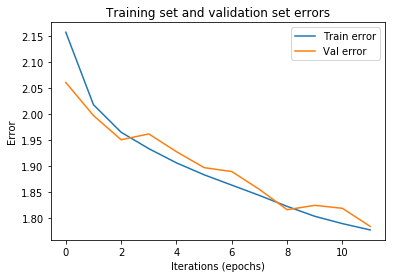

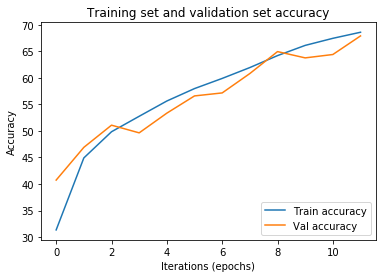

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 69.66% | 69.50%|
| Accuracy of: automobile | 82.32% | 82.06%|
| Accuracy of: bird       | 40.76% | 40.64%|
| Accuracy of: cat        | 45.04% | 44.90%|
| Accuracy of: deer       | 59.30% | 60.00%|
| Accuracy of: dog        | 65.68% | 65.76%|
| Accuracy of: frog       | 77.50% | 77.50%|
| Accuracy of: horse      | 78.76% | 78.54%|
| Accuracy of: ship       | 88.82% | 89.18%|
| Accuracy of: truck      | 70.48% | 70.82%|


In [12]:
dense_model = models.densenet121(pretrained=False)
num_ftrs = dense_model.classifier.in_features
dense_model.classifier = nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax(-1))
# resnet_model.classifier.requires_grad = True
dense_model = dense_model.to(device)
brain = NetworkAPI(dense_model, dataloaders, 'densenet', lr=0.1)
brain.load_checkpoint()
errors = brain.train_loop(epochs=3)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

====== HYPERPARAMETERS ======
starting epoch= 9
epochs to go= 3
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:  10 | Time:  23.11s | Train loss:  1.78 | Train acc: 68.13|
| Epoch:  10 | Time:  12.19s | Val loss:    1.74 | Val acc:   71.82|
--------------------------------------------------------------------
| Epoch:  11 | Time:  29.73s | Train loss:  1.77 | Train acc: 68.76|
| Epoch:  11 | Time:  12.01s | Val loss:    1.73 | Val acc:   72.85|
--------------------------------------------------------------------
| Epoch:  12 | Time:  22.81s | Train loss:  1.76 | Train acc: 69.72|
| Epoch:  12 | Time:  10.85s | Val loss:    1.72 | Val acc:   73.83|
--------------------------------------------------------------------
| Total time elapsed: 1 minutes 50 seconds 


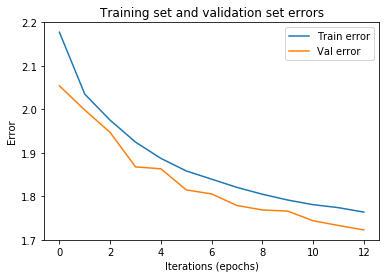

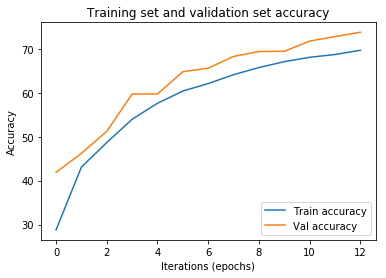

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 75.94% | 75.54%|
| Accuracy of: automobile | 86.94% | 86.30%|
| Accuracy of: bird       | 62.82% | 63.24%|
| Accuracy of: cat        | 54.04% | 53.60%|
| Accuracy of: deer       | 64.04% | 63.24%|
| Accuracy of: dog        | 63.18% | 63.86%|
| Accuracy of: frog       | 84.18% | 84.38%|
| Accuracy of: horse      | 73.28% | 73.44%|
| Accuracy of: ship       | 88.34% | 88.22%|
| Accuracy of: truck      | 86.66% | 86.52%|


In [13]:
model = Network().to(device)
brain = NetworkAPI(model, dataloaders, 'my_architecture', lr=0.1)
brain.load_checkpoint()
errors = brain.train_loop(epochs=3)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)